In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import re
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
import joblib
import nltk
from nltk.tokenize import word_tokenize

In [6]:
# Muat dataset
try:
    df = pd.read_csv("gojek.csv", low_memory=False)
except FileNotFoundError:
    print("Error: File 'gojek.csv' tidak ditemukan.")
    exit()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1650458 entries, 0 to 1650457
Data columns (total 11 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   reviewId              1650458 non-null  object
 1   userName              1650458 non-null  object
 2   userImage             1650458 non-null  object
 3   content               1650250 non-null  object
 4   score                 1650458 non-null  int64 
 5   thumbsUpCount         1650458 non-null  int64 
 6   reviewCreatedVersion  1247849 non-null  object
 7   at                    1650458 non-null  object
 8   replyContent          171009 non-null   object
 9   repliedAt             171009 non-null   object
 10  appVersion            1247849 non-null  object
dtypes: int64(2), object(9)
memory usage: 138.5+ MB


In [8]:
# Periksa nilai yang hilang
print("\nNilai yang Hilang:")
print(df.isna().sum())


Nilai yang Hilang:
reviewId                      0
userName                      0
userImage                     0
content                     208
score                         0
thumbsUpCount                 0
reviewCreatedVersion     402609
at                            0
replyContent            1479449
repliedAt               1479449
appVersion               402609
dtype: int64


In [9]:
# Periksa nilai unik di kolom 'score'
print("\nSkor Unik:", df['score'].unique())


Skor Unik: [5 1 4 3 2 0]


In [10]:
# Periksa baris duplikat
print("\nJumlah Baris Duplikat:", df.duplicated().sum())


Jumlah Baris Duplikat: 0


In [11]:
# Pembersihan Data: Pilih kolom relevan dan konversi 'at' ke datetime
df = df[['content', 'score', 'thumbsUpCount', 'at']]
df['at'] = pd.to_datetime(df['at'])
df['month'] = df['at'].dt.to_period('M')

In [12]:
# Ambil sampel acak 20.000 baris jika dataset lebih besar
df1 = df.sample(n=20000, random_state=42) if len(df) > 20000 else df
df1['content'] = df1['content'].fillna('')
# hapus baris dengan score nol
df1 = df1[df1['score'] != 0]

In [13]:
# Inisialisasi stemmer dan penghapus kata berhenti dari Sastrawi
stemmer_factory = StemmerFactory()
stemmer = stemmer_factory.create_stemmer()

stopword_factory = StopWordRemoverFactory()
stopword_remover = stopword_factory.create_stop_word_remover()

In [14]:
# Daftar kata berhenti khusus
custom_stopwords = ['nya', 'aplikasi', 'yg', 'yang', 'driver']

# Fungsi untuk preprocessing teks dengan penanganan negasi
def preprocess_text(text):
    # Pastikan input adalah string
    if not isinstance(text, str):
        text = str(text)
    
    # Konversi ke huruf kecil
    text = text.lower()
    # Hapus karakter khusus kecuali spasi dan kata
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenisasi
    words = word_tokenize(text)
    # Hapus kata berhenti default Sastrawi
    text_no_stopwords = stopword_remover.remove(' '.join(words))
    # Hapus kata berhenti khusus
    words = text_no_stopwords.split()
    filtered_words = [word for word in words if word not in custom_stopwords]
    # Pastikan negasi seperti 'tidak' tetap ada
    text_no_custom_stopwords = ' '.join(filtered_words)
    # Terapkan stemming
    stemmed_text = stemmer.stem(text_no_custom_stopwords)
    return stemmed_text

# Terapkan preprocessing ke kolom 'content'
df1['content_processed'] = df1['content'].apply(preprocess_text)

C:\Users\BUDI\AppData\Local\Temp\ipykernel_19968\1984386145.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='score', data=df1, palette='Set2')


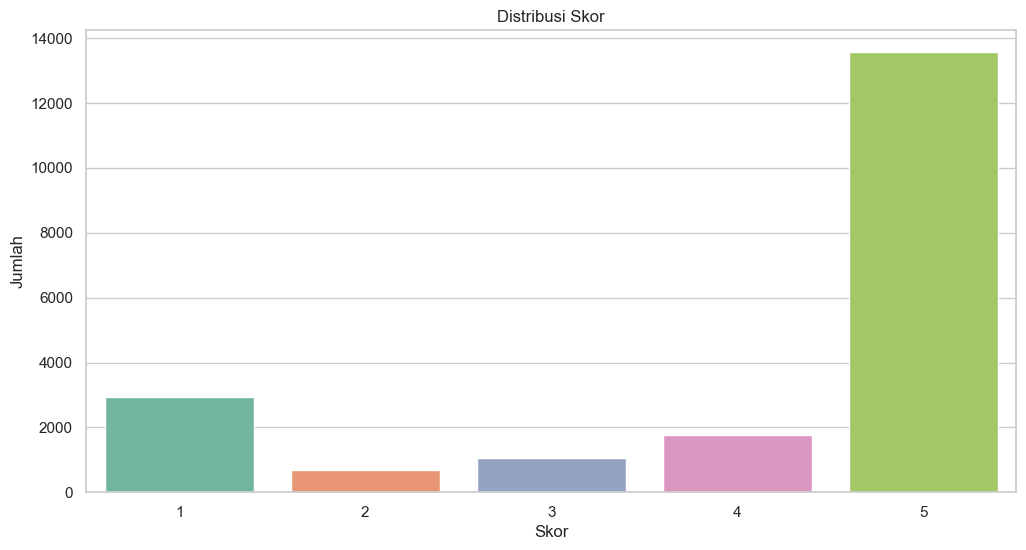

In [15]:
# EDA: Atur gaya untuk plot
sns.set(style="whitegrid")

# Plot distribusi skor
plt.figure(figsize=(12, 6))
sns.countplot(x='score', data=df1, palette='Set2')
plt.title('Distribusi Skor')
plt.xlabel('Skor')
plt.ylabel('Jumlah')
plt.show()


Komentar dengan thumbs up terbanyak: Map-nya tolong dibenerin, ga sesuai arahannya. Customer maupun drivernya jd sering bermasalah, sy sering di Cancel secara sepihak krn problem ini. Over-all, drivernya bagus, gercep dan aplikasinya sudah bagus. tp klo tidak didukung dengan system yg bagus akan rusak juga. Terima kasih.


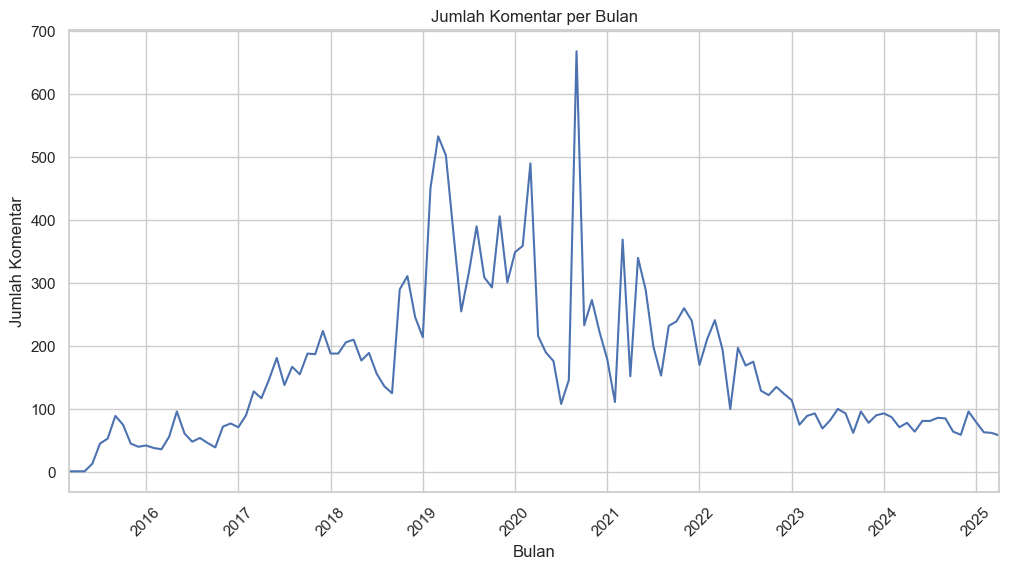

In [16]:
# Temukan komentar dengan thumbs up terbanyak
max_thumbs_up_comment = df1.loc[df1['thumbsUpCount'].idxmax(), 'content']
print("\nKomentar dengan thumbs up terbanyak:", max_thumbs_up_comment)

# Hitung jumlah komentar per bulan
monthly_comment = df1['month'].value_counts().sort_index()

# Plot grafik garis jumlah komentar per bulan
plt.figure(figsize=(12, 6))
monthly_comment.plot(kind='line')
plt.title('Jumlah Komentar per Bulan')
plt.xlabel('Bulan')
plt.ylabel('Jumlah Komentar')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [17]:
# Distribusi score
score_distribution = df1.groupby('score').size()
print("Distribusi Score:\n", score_distribution)

# Kata-kata yang sering muncul untuk setiap score
from collections import Counter
for score in df1['score'].unique():
    words = ' '.join(df1[df1['score'] == score]['content_processed']).split()
    word_freq = Counter(words).most_common(10)
    print(f"\nKata yang sering muncul untuk score {score}:")
    print(word_freq)

Distribusi Score:
 score
1     2925
2      697
3     1044
4     1768
5    13566
dtype: int64

Kata yang sering muncul untuk score 5:
[('sangat', 2272), ('bantu', 1826), ('bagus', 1474), ('gojek', 1459), ('good', 1014), ('mantap', 994), ('baik', 731), ('mudah', 580), ('sekali', 408), ('layan', 376)]

Kata yang sering muncul untuk score 1:
[('gojek', 713), ('ga', 441), ('gak', 441), ('mau', 404), ('gopay', 392), ('udah', 306), ('aja', 298), ('lama', 287), ('makin', 268), ('di', 261)]

Kata yang sering muncul untuk score 4:
[('bantu', 209), ('bagus', 179), ('sangat', 176), ('gojek', 171), ('baik', 111), ('good', 106), ('layan', 80), ('lebih', 71), ('go', 65), ('mudah', 65)]

Kata yang sering muncul untuk score 2:
[('gojek', 197), ('ga', 102), ('mau', 101), ('gak', 96), ('padahal', 84), ('jadi', 77), ('udah', 76), ('gopay', 72), ('lama', 71), ('aja', 67)]

Kata yang sering muncul untuk score 3:
[('gojek', 188), ('mau', 114), ('ga', 92), ('baik', 90), ('gak', 82), ('order', 76), ('go', 73),

## Insight:
Kepuasan Pengguna (Skor 5 dan 4)
- Mayoritas ulasan masih memberikan skor 5, menunjukkan
tingkat kepuasan pengguna yang sangat tinggi secara keseluruhan.
- Skor 4 juga menunjukkan kepuasan dengan sedikit kritik ringan, mirip dengan dataset sebelumnya.
- Kata "cepat" dan "mudah" menunjukkan bahwa kecepatan dan kemudahan layanan menjadi nilai tambah yang signifikan.
- rekomendasi:
Pertahankan kecepatan dan kemudahan layanan, karena ini menjadi alasan utama kepuasan.
Promosikan fitur-fitur yang dianggap "membantu" untuk mempertahankan loyalitas pengguna.

Ketidakpuasan Pengguna (Skor 1 dan 2)
- Skor 1 menunjukkan keluhan utama terkait keterlambatan ("lama"), proses pemesanan ("pesan").
- Skor 2 juga mengeluhkan keterlambatan ("lama"), masalah pemesanan ("pesan" 8 kali).
- Rekomendasi:
Prioritaskan peningkatan kecepatan layanan, terutama untuk pengiriman atau respons (misalnya, optimasi rute driver atau sistem antrian).
Perbaiki sistem pemesanan (GoFood, GoRide, dll.) untuk mengurangi masalah seperti keterlambatan atau pesanan yang tidak terproses ("pesan").

Pengguna Netral (Skor 3)
- Skor 3 menunjukkan campuran pujian dan kritik, dengan fokus pada keterlambatan ("lama") dan pengalaman pemesanan makanan ("makan").
- Tingkatkan layanan GoFood dengan mempercepat pengiriman makanan, karena "makan" dan "lama" sering muncul.

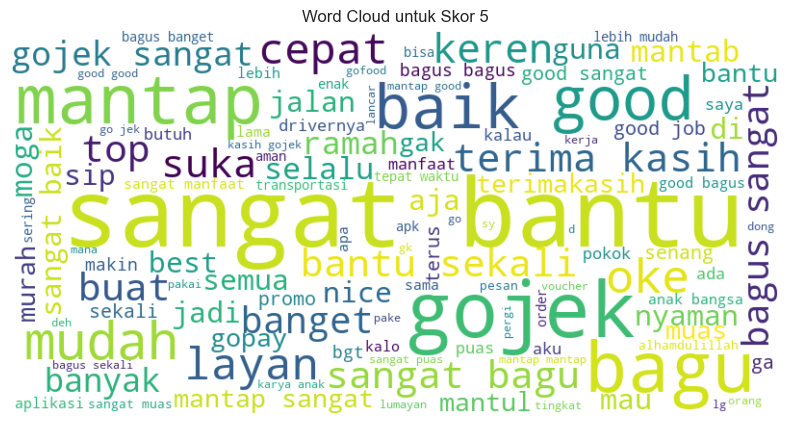

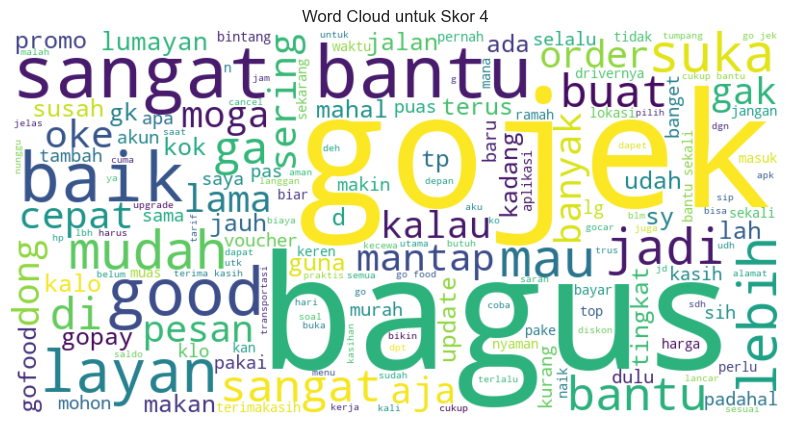

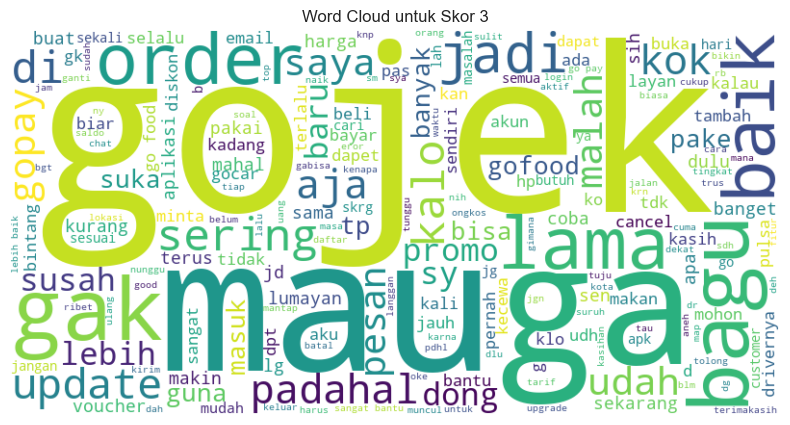

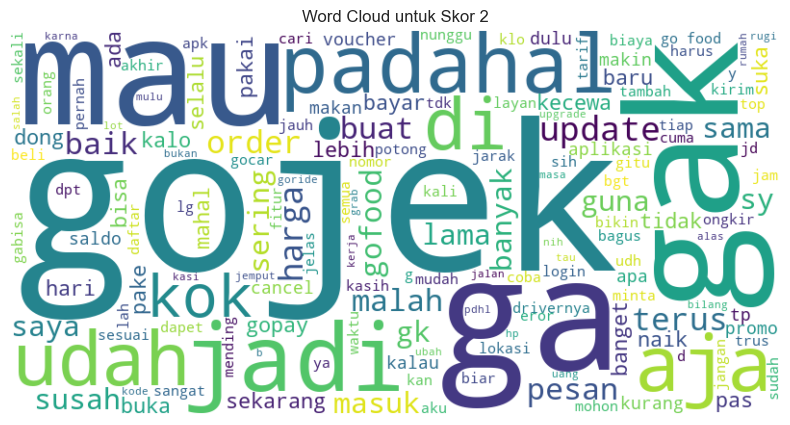

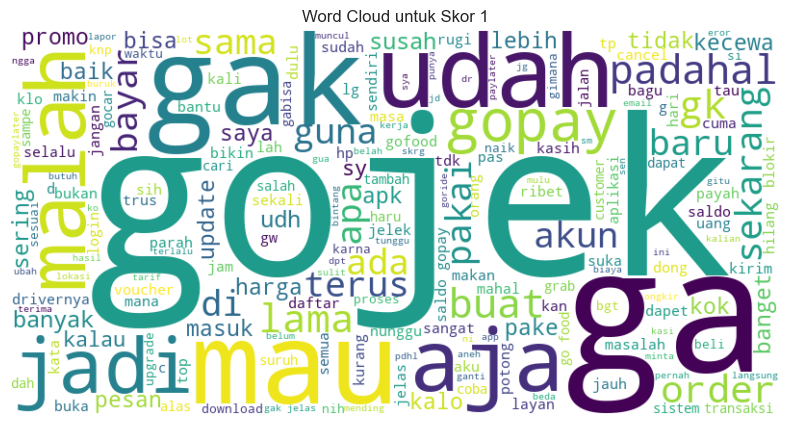

In [18]:
for score in range(5, 0, -1):
    # Ambil teks dari 'content_processed' untuk skor tertentu
    text = ' '.join(df1[df1['score'] == score]['content_processed'].dropna())
    
    # Buat word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white',
                         min_font_size=10).generate(text)
    
    # Tampilkan word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud untuk Skor {score}')
    plt.show()

In [19]:
# Analisis Sentimen: Tentukan label sentimen
def label_sentiment(score):
    if score >= 4:
        return 'positif'
    elif score == 3:
        return 'netral'
    else:
        return 'negatif'

df1['sentiment'] = df1['score'].apply(label_sentiment)

# Periksa distribusi sentimen
print("\nDistribusi Sentimen Sebelum SMOTE:")
print(df1['sentiment'].value_counts())


Distribusi Sentimen Sebelum SMOTE:
sentiment
positif    15334
negatif     3622
netral      1044
Name: count, dtype: int64


In [20]:
# Ekstraksi Fitur dengan TF-IDF (perluas ngram_range untuk menangkap frasa negatif)
vectorizer = TfidfVectorizer(max_features=2000, ngram_range=(1, 3))  # Menangkap unigram, bigram, dan trigram
X = vectorizer.fit_transform(df1['content_processed'])
y = df1['sentiment']

# Seimbangkan dataset dengan SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Periksa distribusi sentimen setelah SMOTE
print("\nDistribusi Sentimen Setelah SMOTE:")
print(pd.Series(y_resampled).value_counts())

d:\master program\anaconda\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(



Distribusi Sentimen Setelah SMOTE:
sentiment
positif    15334
negatif    15334
netral     15334
Name: count, dtype: int64


In [21]:
# Pisahkan data menjadi set pelatihan dan uji
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [22]:
# Optimasi Model dengan Grid Search (perluas parameter)
param_grid = {
    'C': [0.1, 1, 10, 100],  # Perluas rentang C
    'kernel': ['linear', 'rbf', 'sigmoid'],  # Tambah kernel sigmoid
    'class_weight': ['balanced', None]
}

model = SVC(random_state=42)
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Tampilkan parameter terbaik dan skor
print("\nParameter Terbaik:", grid_search.best_params_)
print("Skor F1 Macro Terbaik:", grid_search.best_score_)


Parameter Terbaik: {'C': 100, 'class_weight': 'balanced', 'kernel': 'rbf'}
Skor F1 Macro Terbaik: 0.8443951279680671


In [28]:
# Evaluasi model terbaik pada data uji
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print("\nLaporan Klasifikasi untuk Model Teroptimasi:")
print(classification_report(y_test, y_pred))


Laporan Klasifikasi untuk Model Teroptimasi:
              precision    recall  f1-score   support

     negatif       0.91      0.85      0.88      3155
      netral       0.90      0.80      0.85      3069
     positif       0.76      0.90      0.82      2977

    accuracy                           0.85      9201
   macro avg       0.86      0.85      0.85      9201
weighted avg       0.86      0.85      0.85      9201



In [29]:
# Simpan model dan vectorizer
joblib.dump(best_model, 'optimized_sentiment_model.pkl')
joblib.dump(vectorizer, 'optimized_tfidf_vectorizer.pkl')

['optimized_tfidf_vectorizer.pkl']

In [30]:
# Fungsi untuk memprediksi sentimen ulasan baru
def predict_sentiment(new_review):
    processed_review = preprocess_text(new_review)
    new_review_tfidf = vectorizer.transform([processed_review])
    prediction = best_model.predict(new_review_tfidf)[0]
    return prediction

In [ ]:
# Contoh pengujian dengan kata
new_reviews = [
    "layanan buruk sekali",
    "sangat puas dengan gojek",
    "biasa saja pelayanannya",
    ]

for review in new_reviews:
    sentiment = predict_sentiment(review)
    print(f"Ulasan: '{review}' -> Sentimen: {sentiment}")

Ulasan: 'layanan buruk sekali' -> Sentimen: negatif
Ulasan: 'sangat puas dengan gojek' -> Sentimen: positif
Ulasan: 'biasa saja pelayanannya' -> Sentimen: netral
